# MBTI Prediction

In [2]:
import pandas as pd

data = pd.read_csv("./data/mbti_1.csv", header = 0)

data.head()


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## Dataset Analysis

In [19]:
print("Data shape is: {0}, and has columns {1}".format(data.shape, data.columns))

type_count = data.type.value_counts()

Data shape is: (8675, 2), and has columns Index(['type', 'posts'], dtype='object')


### Distribution of types of dataset users

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


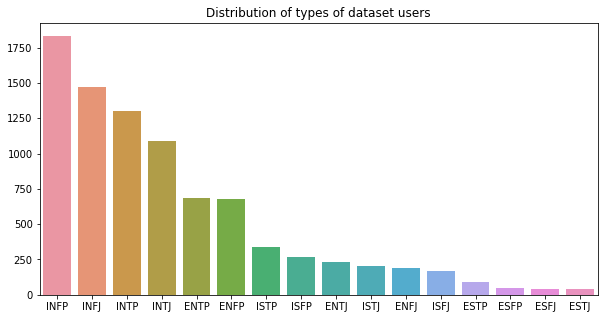

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

print(type_count)
plt.figure(figsize=(10,5))
sns.barplot(type_count.index, type_count.values)
plt.title('Distribution of types of dataset users')
plt.show()

Here we can see that the population is not equally distributed. We have almost 2000 posts from the type INFP but less than 50 on ESTJ. It may represent the population, but it means that the prediction will be much more effective for INFP than on ESTJ.

### Number of words in posts by type
It may be interesting to calculate the average number of words by type to see if there is a notable difference.
Inspired by data analysis on https://www.kaggle.com/laowingkin/mbti-study-personality

In [14]:
def parse_posts(posts):
    return posts.split("|||")

def number_words_in_post(post):
    return len(post.split())

data['number_of_words'] = data['posts'].apply(lambda posts: sum([number_words_in_post(post) for post in parse_posts(posts)])/50)

print(data.head())
print(data.groupby(data.type)["number_of_words"].mean())

   type                                              posts  number_of_words
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...            12.10
1  ENTP  'I'm finding the lack of me in these posts ver...            24.38
2  INTP  'Good one  _____   https://www.youtube.com/wat...            17.70
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...            22.26
4  ENTJ  'You're fired.|||That's another silly misconce...            20.32
type
ENFJ    26.688421
ENFP    26.160326
ENTJ    25.312641
ENTP    25.077197
ESFJ    26.750476
ESFP    21.344167
ESTJ    25.551795
ESTP    24.203820
INFJ    26.526925
INFP    25.848035
INTJ    24.831659
INTP    24.904709
ISFJ    25.783012
ISFP    23.664797
ISTJ    25.204585
ISTP    24.267240
Name: number_of_words, dtype: float64


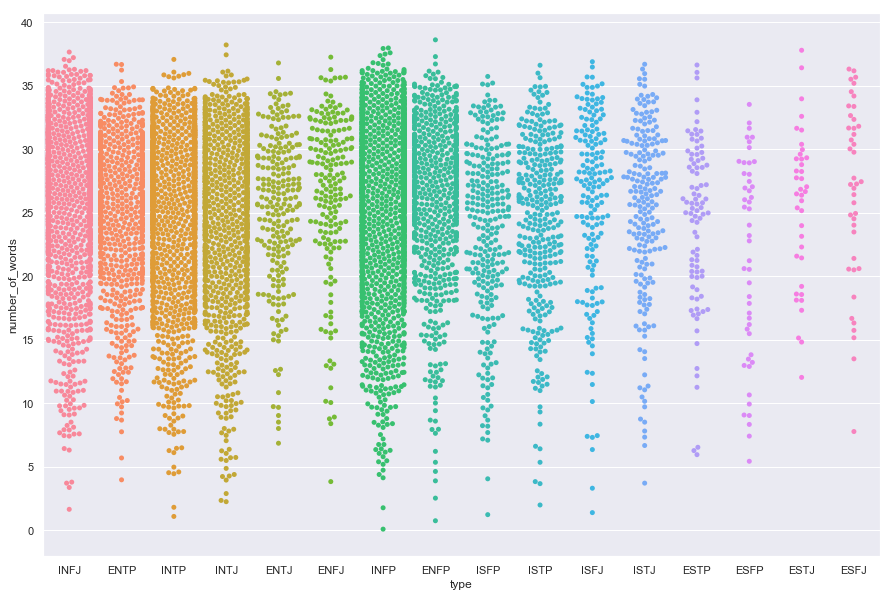

In [63]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "number_of_words", data=data)

### Vocabulary by type
Here we will analyze the vocabulary used by types of user and see if there is a trend.

In [18]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
  
lemmatizer = nltk.WordNetLemmatizer()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def get_vocab(post):
    words = tokenizer.tokenize(post)
    words = [word.lower() for word in words]
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    filtered_sentence = [w for w in words if not w in stop_words]
    lemms = [lemmatizer.lemmatize(word) for word in filtered_sentence]
    return nltk.FreqDist(lemms)


types = data.type.unique()
def get_vocab_type(data):
    for type in types:
        posts = ""
        post = data.loc[data['type'] == type, :]['posts']
        posts = [p for p in post]
        long_post = ". ".join(posts)
        most_common = [word[0] for word in get_vocab(long_post).most_common(10)]
        print("Most common words for type {0} are {1}".format(type, most_common))
        


# print(get_vocab(data.posts[1]).most_common(10))
get_vocab_type(data)

[nltk_data] Downloading package punkt to /Users/cecile/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/cecile/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most common words for type INFJ are ['like', 'think', 'people', 'know', 'one', 'infj', 'really', 'thing', 'time', 'would']
Most common words for type ENTP are ['like', 'think', 'people', 'one', 'entp', 'know', 'get', 'would', 'thing', 'really']
Most common words for type INTP are ['like', 'think', 'people', 'one', 'would', 'know', 'intp', 'thing', 'time', 'get']
Most common words for type INTJ are ['like', 'people', 'think', 'one', 'intj', 'would', 'know', 'time', 'thing', 'get']
Most common words for type ENTJ are ['like', 'think', 'people', 'one', 'entj', 'would', 'get', 'know', 'thing', 'type']
Most common words for type ENFJ are ['like', 'think', 'people', 'know', 'really', 'enfj', 'one', 'thing', 'get', 'would']
Most common words for type INFP are ['like', 'think', 'people', 'really', 'one', 'know', 'thing', 'time', 'infp', 'feel']
Most common words for type ENFP are ['like', 'think', 'people', 'enfp', 'know', 'one', 'really', 'thing', 'get', 'time']
Most common words for type ISF

## Learning